# **Autoencoder per intrusion detection**

*Progetto finale corso Machine Learning, Università di Roma Tor Vergata,
Martina Lupini & Michele Tosi*

Il seguente progetto pone come obiettivo la costruzione di un autoencoder per il rilevamento di "flussi" anomali. Il dataset di riferimento è il dataset NSL-KDD, utilizzato come benchmark nei problemi di intrusion detection.

Il dataset in esame prevede:

- caratteristiche di **base**:

  - **duration**: Durata della connessione (in secondi).
  - **protocol_type**: Tipo di protocollo.
  - **service**: Servizio di destinazione.
  - **flag**: Stato della connessione.
  - **src_bytes**: Byte inviati dalla sorgente.
  - **dst_bytes**: Byte ricevuti dalla destinazione.
  - **land**: Se la connessione è fra host e porta identici.
  - **wrong_fragment**: Numero di frammenti sbagliati.
  - **urgent**: Numero di pacchetti urgenti.

- caratteristiche legate al **contenuto**:
  - **hot**: Numero di accessi "caldi" a file di sistema.
  - **num_failed_logins**: Numero di login falliti.
  - **logged_in**: Se il login è avvenuto con successo.
  - **num_compromised**: Numero di condizioni compromesse.
  - **root_shell**: Se è stato ottenuto accesso a shell root.
  - **su_attempted**: Numero di tentativi di eseguire il comando su.
  - **num_root**: Numero di accessi a privilegi di root.
  - **num_file_creations**: Numero di creazioni di file.
  - **num_shells**: Numero di shell aperte.
  - **num_access_files**: Numero di accessi a file.
  - **num_outbound_cmds**: Numero di comandi outbound.
  - **is_host_login**: Se l'utente è un host login.
  - **is_guest_login**: Se l'utente è un guest login.

- caratteristiche derivate dal traffico:

  - **count**: Numero di connessioni alla stessa host nell'ultimo intervallo.
  - **srv_count**: Numero di connessioni allo stesso servizio nell'ultimo intervallo.
  - **serror_rate**: Percentuale di connessioni con errori SYN.
  - **srv_serror_rate**: Percentuale di connessioni allo stesso servizio con errori SYN.
  - **rerror_rate**: Percentuale di connessioni con errori di tipo REJ.
  - **srv_rerror_rate**: Percentuale di connessioni allo stesso servizio con errori REJ.
  - **same_srv_rate**: Percentuale di connessioni allo stesso servizio.
  - **diff_srv_rate**: Percentuale di connessioni a servizi diversi.
  - **srv_diff_host_rate**: Percentuale di connessioni a host diversi per lo stesso servizio.


- caratteristiche derivate sull'**intervallo temporale** tra host differenti:
  - **dst_host_count**: Numero di connessioni alla stessa host.
  - **dst_host_srv_count**: Numero di connessioni alla stessa host per lo stesso servizio.
  - **dst_host_same_srv_rate**: Percentuale di connessioni alla stessa host per lo stesso servizio.
  - **dst_host_diff_srv_rate**: Percentuale di connessioni alla stessa host per servizi diversi.
  - **dst_host_same_src_port_rate**: Percentuale di connessioni alla stessa host e stessa porta sorgente.
  - **dst_host_srv_diff_host_rate**: Percentuale di connessioni a diverse host per lo stesso servizio.
  - **dst_host_serror_rate**: Percentuale di connessioni alla stessa host con errori SYN.
  - **dst_host_srv_serror_rate**: Percentuale di connessioni alla stessa host e servizio con errori SYN.
  - **dst_host_rerror_rate**: Percentuale di connessioni alla stessa host con errori di tipo REJ.
  - **dst_host_srv_rerror_rate**: Percentuale di connessioni alla stessa host e servizio con errori REJ.

Infine, si ha la **label** che indica se la connessione è normale (`normal`) o rappresenta un attacco (in particolare nel dataset vengono indicate varie classi possibili per gli attacchi, nel caso di studio di autoencoder per anomaly detection non siamo interessati a questa ulteriore classificazione, ci basta distinguere tra connessioni normali e anomale).

In [ ]:
# Verifica se keras-tuner è installato
try:
    import keras_tuner
    print("keras-tuner è già installato.")
except ImportError:
    print("keras-tuner non trovato. Installazione in corso...")
    !pip install keras-tuner

# Verifica se scikeras è installato
try:
    import scikeras
    print("scikeras è già installato.")
except ImportError:
    print("scikeras non trovato. Installazione in corso...")
    !pip install scikeras

keras-tuner è già installato.
scikeras è già installato.


In [ ]:

import tensorflow as tf
import sklearn
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
from keras_tuner import HyperParameters, Hyperband
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #per la confusion matrix
import seaborn as sns #per box-plot
from sklearn.decomposition import PCA

# Prima visualizzazione del dataset
Per prima cosa visualizziamo le informazioni base sul dataset.

In [ ]:
file_path = "KDDTrainClean.csv"
data = pd.read_csv(file_path)

# Informazioni generali sul dataset
print("\nInformazioni sul dataset:")
print(data.info())


Informazioni sul dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              12

Come possiamo vedere non ci sono valori nulli. Inoltre le variabili categoriche sono tre (quattro se si considera anche il label finale): *protocol_type*, *service*, *flag*.

In [ ]:
# Visualizza le prime righe
print("Prime righe del dataset:")
print(data.head())

Prime righe del dataset:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10   

# Preprocessamento dati
Nella prima fase vengono svolte delle operazioni preliminari sui dati quali:
1. One Hot Encoding delle features categoriche.
1. Separazione delle istanze in anomale e non anomale. Le operazioni fatte successivamente (come ad esempio la normalizzazione) potranno beneficiare di questa separazione andando ad operare solo sui dati non anomali. Infatti, l'obiettivo è costruire un autoencoder che ricostruisca in modo ottimale le istanze non anomale. In tutta la fase di addestramento considereremo solo training e validation set contenenti istanze non anomale.
2. Rimozione etichette.
3. Divisione in training, validation e test set. In particolare il training set è costituito da istanze che non presentano anomalie. Si hanno due validation set:
      - Uno con istanze senza anomalie non etichettate (che verrà utilizzato durante l'addestramento del modello e per determinare le threshold).
      - Uno con istanze miste (utilizzato per valutare le threshold).
4. Applicazione di *MinMaxScaler()* che trasforma il valore di ogni colonna in proporzione entro il range [0,1]. Il vantaggio di questa trasformazione è che limita il range dei valori assunti dalle features senza però causare distorzione del dataset.

In [ ]:
categorical_columns = ['protocol_type', 'service', 'flag']

def preprocess_kdd99_with_anomalies(data):

    # Separazione dei dati normali senza la codifica OHE
    NO_ONE_HOT = data[data['label'] == 'normal']

    # One-hot encoding per le features categoriche
    data = pd.get_dummies(data, columns=categorical_columns)

    # Separazione dei dati normali e anomali
    normal_data = data[data['label'] == 'normal']
    anomalous_data = data[data['label'] != 'normal']

    # Rimuovi l'etichetta dai dataset
    normal_data = normal_data.drop(columns=['label'])
    anomalous_data = anomalous_data.drop(columns=['label'])

    # Divisione dei dati normali in training, validation e test set
    indices = np.arange(normal_data.shape[0])
    X_train, X_temp, indices_train, indices_temp = train_test_split(normal_data, indices, test_size=0.3, random_state=42)  # 70% training
    X_val_normal, X_test_normal = train_test_split(X_temp, test_size=0.5, random_state=42)

    # Divisione dei dati anomali in validation e test set
    X_val_anomalous, X_test_anomalous = train_test_split(anomalous_data, test_size=0.5, random_state=42)

    # Prepara i dati di validazione (normali + anomali)
    len_val = len(X_val_normal)
    X_val = pd.concat([X_val_normal, X_val_anomalous.iloc[:len_val]], axis=0)
    y_val = [0] * len(X_val_normal) + [1] * len_val  # Etichette: 0 = normale, 1 = anomalo

    # Prepara i dati di test (normali + anomali)
    len_test = len(X_test_normal)
    X_test = pd.concat([X_test_normal, X_test_anomalous.iloc[:len_test]], axis=0)
    y_test = [0] * len(X_test_normal) + [1] * len_test

    # Applica lo scaler **dopo** la divisione
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Fit sul training set
    X_val_scaled = scaler.transform(X_val)         # Transform su validation
    X_val_normal = scaler.transform(X_val_normal)
    X_val_anomalous = scaler.transform(X_val_anomalous)
    X_test_scaled = scaler.transform(X_test)       # Transform su test

    # Converti in DataFrame per mantenere i nomi delle colonne
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    X_val_normal = pd.DataFrame(X_val_normal, columns=X_val.columns)
    X_val_anomalous = pd.DataFrame(X_val_anomalous, columns=X_val.columns)

    X_train_extracted = NO_ONE_HOT.iloc[indices_train]

    return X_train_scaled, X_val_scaled, y_val, X_test_scaled, y_test, X_val_normal, X_val_anomalous, X_train_extracted

X_train, X_val, y_val, X_test, y_test, X_val_normal, X_val_anomalous, X_train_extracted = preprocess_kdd99_with_anomalies(data)

# Esplorazione del dataset

Ora che il dataset è stato diviso si può procedere a studiare come è costituito il training set. Per semplificare lo studio consideriamo il training set prima che le variabili categoroiche vengano tasformate con la OHE (altrimenti si avrebbero troppe features).

In [ ]:
# Statistiche descrittive
print("\nStatistiche descrittive:")
print(X_train_extracted.describe())


Statistiche descrittive:
           duration     src_bytes     dst_bytes          land  wrong_fragment  \
count  47140.000000  4.714000e+04  4.714000e+04  47140.000000         47140.0   
mean     163.279317  1.314623e+04  4.416887e+03      0.000106             0.0   
std     1291.684593  4.638773e+05  7.015225e+04      0.010298             0.0   
min        0.000000  0.000000e+00  0.000000e+00      0.000000             0.0   
25%        0.000000  1.320000e+02  1.050000e+02      0.000000             0.0   
50%        0.000000  2.340000e+02  3.790000e+02      0.000000             0.0   
75%        0.000000  3.240000e+02  2.065000e+03      0.000000             0.0   
max    40504.000000  8.958152e+07  7.028652e+06      1.000000             0.0   

             urgent           hot  num_failed_logins     logged_in  \
count  47140.000000  47140.000000       47140.000000  47140.000000   
mean       0.000127      0.242024           0.001273      0.712495   
std        0.017233      2.378242 

La feature *wrong_fragment* presenta tutti valori nulli. A primo impatto si potrebbe pensare di rimuoverla, tuttavia, non conoscendone la distribuzione nelle istanze anomale abbiamo deciso di mantenerla.

# Istogrammi per le features numeriche
Costruzione degli istogrammi per le features numeriche

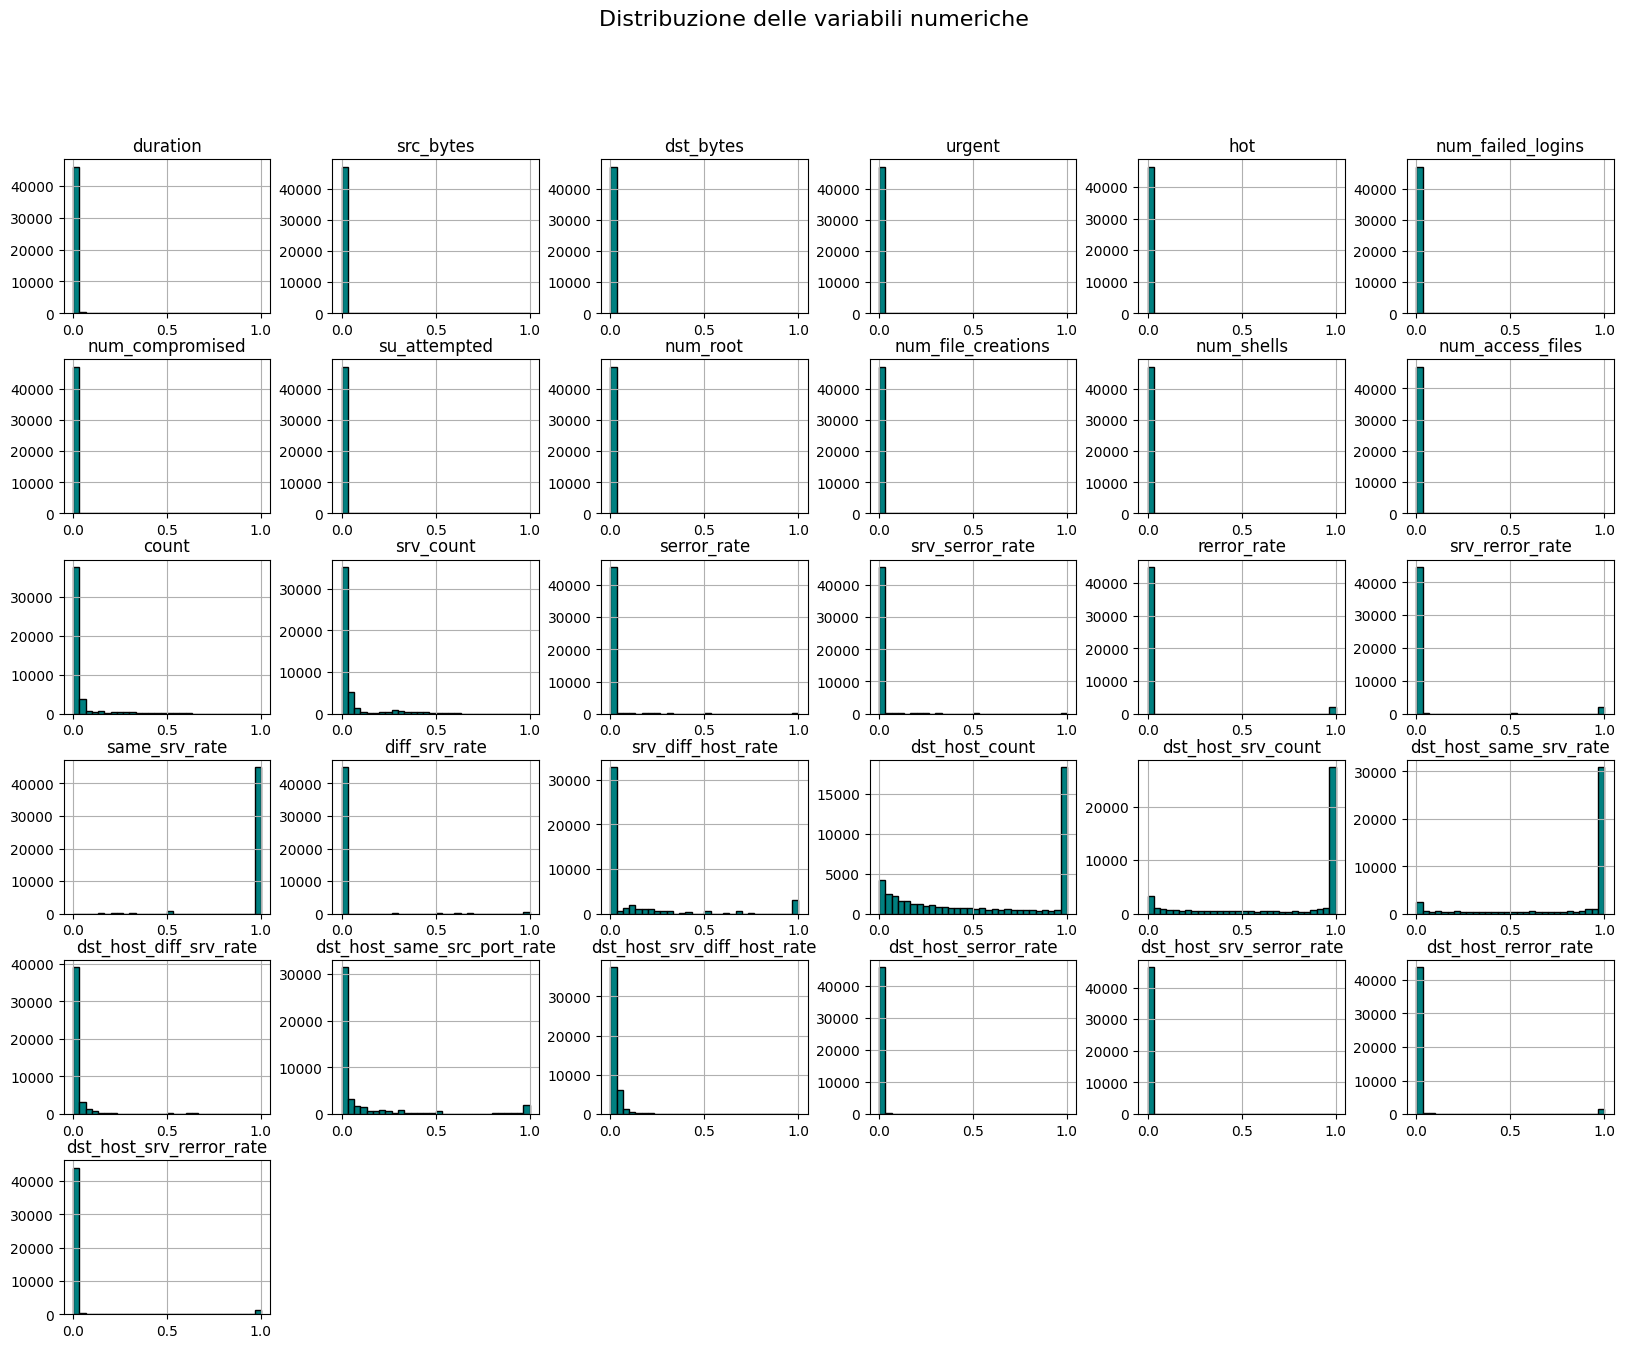

In [ ]:
# Identifica le colonne one-hot encoded (binario 0/1) o quelle contenenti un unico valore
one_hot_columns = [col for col in X_train.columns if (set(X_train[col].unique()) == {0, 1} or X_train[col].nunique() == 1)]

# Seleziona solo le colonne numeriche, escludendo quelle one-hot encoded
numerical_features = X_train.select_dtypes(include=np.number).drop(columns=one_hot_columns)

# Istogrammi per tutte le feature numeriche
numerical_features.hist(bins=30, figsize=(20, 15), color='teal', edgecolor='black')
plt.suptitle("Distribuzione delle variabili numeriche", fontsize=16)
plt.show()

Come aspettato dall'applicazione di *MinMaxScaler()* i valori sono tutti compresi tra [0,1]. In particolare si hanno dei picchi sul valore 0 in quanto molte features assumono il valore 0 già prima dell'uso dello scaler (possiamo vedere ciò dall'output della funzione *describe()*).

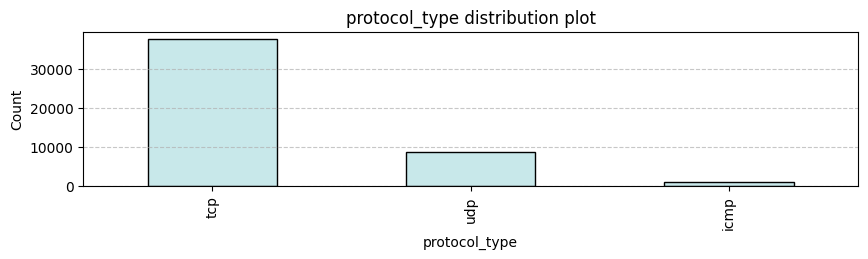

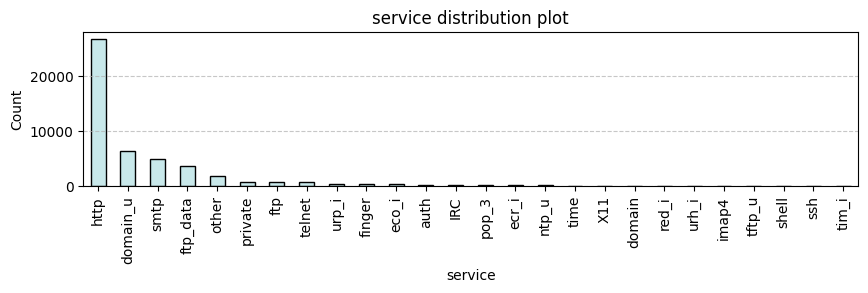

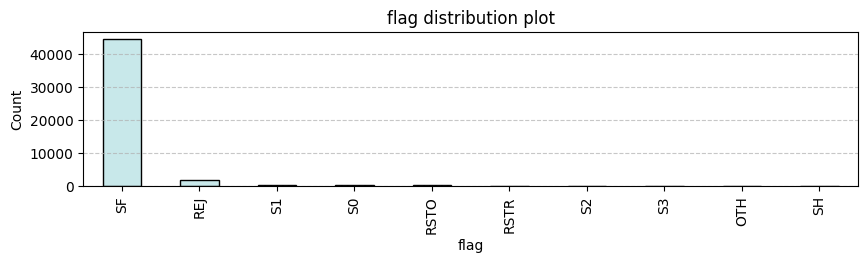

In [ ]:
for feature in categorical_columns:

    X_train_extracted[feature].value_counts().plot(kind='bar', figsize=(10, 2), color='#c8e8ea', edgecolor = "black")

    plt.title(f"{feature} distribution plot", fontsize = 12)
    plt.xlabel(feature, fontsize = 10)
    plt.ylabel("Count", fontsize = 10)
    plt.grid(axis = "y", linestyle = "--", alpha = 0.7)

    plt.show()

Dagli istogrammi ottenuti osserviamo come alcuni valori sono assunti maggiormente dalle feature categoriche mentre altri non sono mai assunti. Essendo il training set composto da istanze non anomale, valori di flag o servizi mai assunti da queste features appartengono sicuramente a flussi malevoli.

# Correlazione tra features

Calcolando la correlazione tra le features notiamo che alcune features sono correlate tra loro. Tuttavia, abbiamo deciso di lasciare tutte le features in modo che l'autoencoder possa estrarre informazioni da esse e apprendere un coding ottimale.

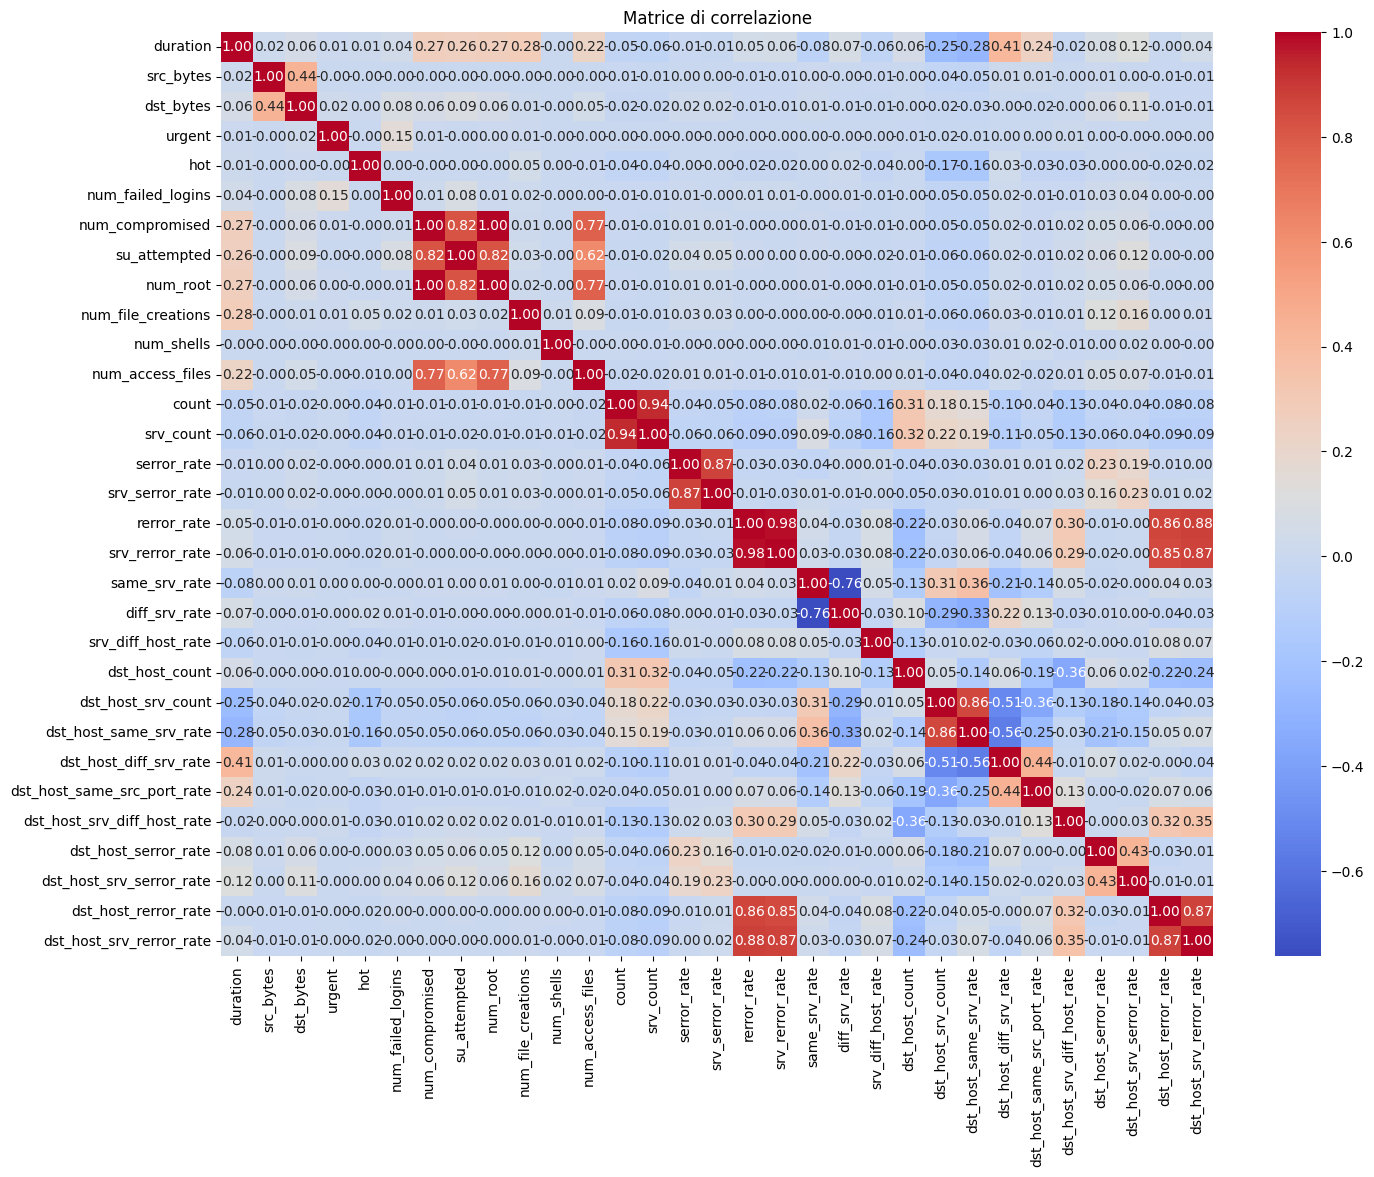

In [ ]:
# Calcolo della matrice di correlazione
correlation_matrix = numerical_features.corr()

# Heatmap delle correlazioni
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice di correlazione")
plt.show()

# Modellazione
In questa fase si procede alla definizione del modello di Autoencoder. Esso presenta un'architettura simmetrica e utilizza ReLU come funzione di attivazione.
Il numero di livelli e il numero di unità per livello non vengono fissati a priori, lasciando al processo di ottimizzazione il compito di determinare la configurazione ottimale. A tal fine, viene utilizzato l'algoritmo Hyperband, un algoritmo di tuning di iperparametri che permette di valutare rapidamente un grande numero di configurazioni, bilanciando esplorazione e sfruttamento.

Per l'ottimizzazione del modello, si utilizza l'algoritmo **Adam** (Adaptive Moment Estimation), scelto per la sua capacità di adattare dinamicamente il tasso di apprendimento, migliorando la velocità e la stabilità della convergenza. Per valutare l'errore del modello, si adotta la **Mean Squared Error** (MSE) come funzione di perdita. La scelta dell'MSE rispetto alla Mean Absolute Error (MAE) è giustificata dal fatto che l'MSE dà maggiore peso agli errori più grandi, aumentando la magnitudine dei valori elevati e trascurando quelli più piccoli. Questo consente di porre maggiore enfasi sulle ricostruzioni significativamente errate.

In [ ]:
# Define the Autoencoder model
def build_autoencoder(hp):
    input_dim = X_train.shape[1]
    model = keras.Sequential()
    nLayers = hp.Int("nLayers", min_value=1, max_value=4, step=1)
    units=hp.Int("units", min_value=100, max_value=300, step=50)

    model.add(keras.layers.Input(shape=(input_dim,)))
    model.add(keras.layers.Flatten())

    # Encoder layers
    for i in range(nLayers):
        model.add(keras.layers.Dense(
                units // (2**i),
                activation="relu")
        )

    model.add(Dense(units // (2**nLayers),
                activation="relu"))

    # Decoder layers
    for i in range(nLayers-1, -1, -1):
        model.add(Dense(units // (2**i), activation='relu'))

    model.add(Dense(input_dim, activation='sigmoid'))

    model.compile(optimizer='adam', loss="mse")

    return model

In [ ]:
build_autoencoder(HyperParameters())

tuner = Hyperband(
    hypermodel=build_autoencoder,
    objective="val_loss",
    overwrite=True,
    directory="/tmp/kerastuner",
    project_name="project",
)

tuner.search_space_summary()

# Ricerca iperparametri migliori
tuner.search(X_train, X_train, validation_data=(X_val_normal, X_val_normal),
             batch_size=tuner.oracle.hyperparameters.Choice('batch_size', [16, 32, 64, 128]))

# Risultato finale del tuning
best_hps = tuner.get_best_hyperparameters(5)

# Costruzione del modello con i migliori valori degli iperparametri
model = build_autoencoder(best_hps[0])

model.summary()

Trial 74 Complete [00h 00m 20s]
val_loss: 0.0003727274888660759

Best val_loss So Far: 0.00022870011162012815
Total elapsed time: 00h 37m 15s


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 122)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 250)                 │          30,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 125)                 │          31,375 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 250)                 │          31,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 122)                 │          30,622 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,247 (485.34 KB)

 Trainable params: 124,247 (485.34 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(best_hps[0].get('batch_size'),
best_hps[0].get('nLayers'),
best_hps[0].get('units'))

16 1 250


# Addestramento
Si procede nell'addestramento del modello utilizzando un training set composto esclusivamente da istanze che non presentano anomalie. Questo approccio consente all'autoencoder di apprendere come ricostruire i dati "normali", ottimizzando così la sua capacità di identificare eventuali anomalie in fase di inferenza.
Poiché il dataset è stato selezionato in modo da includere solo istanze "normali", anche il validation set è composto esclusivamente da dati privi di anomalie. In questa configurazione, è stato introdotto un meccanismo di **early stopping** per monitorare l'andamento dell'errore di ricostruzione sul validation set. In tal modo si evita di addestrare la rete a tal punto che l'errore di ricostruzione sul validation set cominci ad aumentare.
È importante sottolineare che, nel caso in cui il training set contenesse anche istanze anomale, l'adozione di early stopping potrebbe risultare controproducente. In tale scenario, si preferirebbe favorire un certo grado di overfitting sulle istanze non anomale, per consentire al modello di apprendere una rappresentazione più accurata e dettagliata di tali dati, migliorando così la discriminazione tra dati normali e anomalie. La batch size è stata scelta durante la fase di iperparameter tuning.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")
model.compile(optimizer='adam', loss="mse")

# Addestramento
history = model.fit(X_train, X_train, epochs=100,
                    batch_size=best_hps[0].get('batch_size'), # Prende il miglior valore ottenuto come batch_size
                    validation_data=(X_val_normal, X_val_normal),
                    shuffle=True,
                    callbacks=[early_stopping]
                    )


Epoch 1/100
2947/2947 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0106 - val_loss: 6.5707e-04
Epoch 2/100
2947/2947 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 2.4388e-04 - val_loss: 2.6512e-04
Epoch 3/100
2947/2947 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.3762e-04 - val_loss: 2.4245e-04
Epoch 4/100
2947/2947 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.0231e-04 - val_loss: 2.0125e-04
Epoch 5/100
2947/2947 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 9.7807e-05 - val_loss: 2.0143e-04
Epoch 6/100
2947/2947 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.8628e-05 - val_loss: 1.6347e-04
Epoch 7/100
2947/2947 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.2083e-05 - val_loss: 1.5183e-04
Epoch 8/100
2947/2947 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5.8795e-05 - val_loss: 1.6300e-04
Epoch 9/100
2947/2947 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 5.2010e-05 - val_loss: 1.5280e-04
Epoch 10/100
2947/2947 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5.1258e-05 - val_loss: 1.4988e-04
Epoch 11/100
2947/2947 ━━━

# Visualizzazione dei risultati
Vediamo ora le prestazioni dell'autoencoder su dati anomali e dati normali. Nel caso di dati normali l'errore medio di ricostruzione è circa 0.0001. Per quanto rigurda i dati con anomalie il valore atteso è 0.0265.

In [ ]:
# Predizione su dati non anomali
reconstruction = model.predict(X_val_normal)
val_loss = tf.keras.losses.mse(reconstruction, X_val_normal)

print("Mean reconstruction error on normal validation data: "+ str(np.mean(val_loss)))
print("")

# Predizione su dati anomali
reconstruction_a = model.predict(X_val_anomalous)
val_loss_a = tf.keras.losses.mse(reconstruction_a, X_val_anomalous)

print("Mean reconstruction error on anormal validation data: "+ str(np.mean(val_loss_a)))


316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean reconstruction error on normal validation data: 0.00015013345435311982

917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Mean reconstruction error on anormal validation data: 0.02657273657590553


# Calcolo della threshold
Senza dubbio il calcolo della threshold rappresenta una fase cruciale del modello. Infatti una percentuale di istanze normali ha lo stesso errore di ricostruzione di istanze anomale, dunque bisogna cercare un trade-off tra falsi positivi e falsi negativi. Usare una threshold troppo bassa comporterebbe un aumento del numero di falsi positivi. Usare una threshold troppo alta, invece, causa l'aumento dei falsi negativi. Ovviamente in base alle esigenze di chi commissiona il modello si possono preferire dei falsi positi a dei falsi negativi o viceversa.  

In questo lavoro abbiamo analizzato vari modi per calcolare la threshold:
- Threshold basata sul percentile.
- Threshold calcolata con Youden's index.
- Threshold vettoriale.

In [ ]:
def evaluate_threshold(threshold, threshold_type, X_val_pred):

  name= "La threshold "+ threshold_type + " è: " + str(threshold)
  print(name)

  reconstruction_error = np.mean(np.square(X_val - X_val_pred), axis=1)
  y_val_pred = (reconstruction_error > threshold).astype(int)
  title = "Report di classificazione sul set di validazione con threshold " + threshold_type + " : "
  print(title)
  report = classification_report(y_val, y_val_pred, zero_division=0)
  print(report)

  # Matrice di confusione per il set di validazione
  cm_val = confusion_matrix(y_val, y_val_pred)
  disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=["Normale", "Anomalo"])
  disp_val.plot(cmap="Blues")
  plt.title("Matrice di Confusione - Set di Validazione")
  plt.show()

  return precision_score(y_val, y_val_pred), recall_score(y_val, y_val_pred), f1_score(y_val, y_val_pred, average='weighted')

## $95^°$ percentile

Calcoliamo ora la threshold in modo tale che il 95% dei dati non anomali cada al di sotto di tale soglia. Ovviamente in questo modo si abbassa il numero di falsi positivi ma potrebbe aumentare il numero di falsi negativi.


632/632 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
La threshold percentile è: 7.409553983966119e-05
Report di classificazione sul set di validazione con threshold percentile : 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10101
           1       0.95      0.95      0.95     10101

    accuracy                           0.95     20202
   macro avg       0.95      0.95      0.95     20202
weighted avg       0.95      0.95      0.95     20202



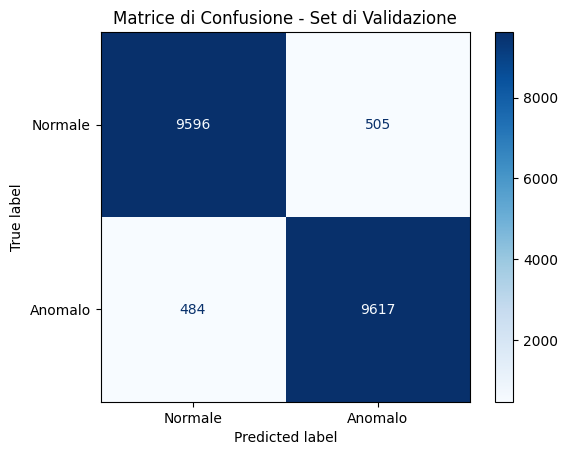

In [ ]:
# Valutazione sul set di validazione
X_val_pred = model.predict(X_val)

threshold_percentile = np.percentile(val_loss, 95)
precision_percentile, recall_percentile, f1_percentile = evaluate_threshold(threshold_percentile, "percentile", X_val_pred)

## Youden's Index

La curva ROC è uno strumento grafico utilizzato per valutare le prestazioni di un classificatore binario variando la soglia di decisione. Essa rappresenta il compromesso tra:
- TPR (True Positive Rate): proporzione di anomalie correttamente identificate, calcolata come $TPR = \frac{TP}{TP+FN}$.
- FPR (False Positive Rate): proporzione di istanze normali classificate erroneamente come anomalie, calcolata come $TPR = \frac{FP}{FP+TN}$.

La curva ROC viene tracciata valutando il TPR e il FPR per diverse thresholds, producendo una linea che mostra come varia il compromesso tra rilevazione di anomalie e falsi allarmi.

L'approccio utilizzato per determinare la threshold si basa sull'indice di Youden (
$J$), definito come:

$J=TPR−FPR$.

L'indice di Youden rappresenta il punto della curva ROC che massimizza la differenza tra il TPR e il FPR. Questo corrisponde alla soglia che bilancia meglio i falsi positivi e i falsi negativi. La formula per la soglia ottimale è:

threshold_optimal = thresholds $[argmax(TPR−FPR)]$

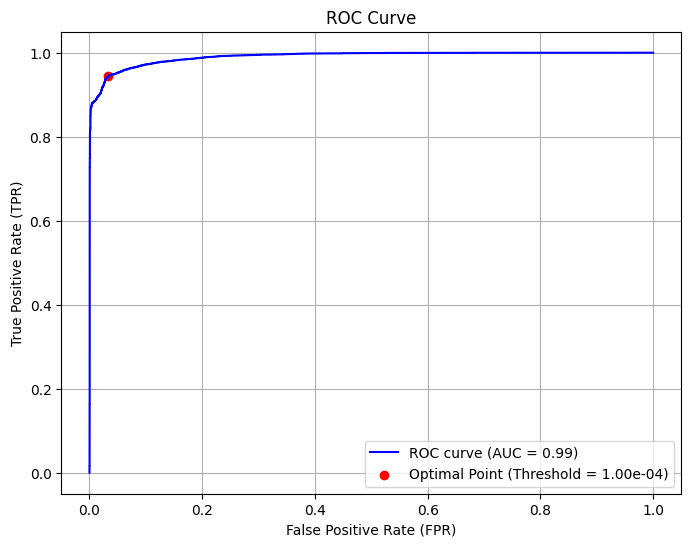

La threshold ROC è: 0.00010043981154384735
Report di classificazione sul set di validazione con threshold ROC : 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     10101
           1       0.97      0.95      0.96     10101

    accuracy                           0.96     20202
   macro avg       0.96      0.96      0.96     20202
weighted avg       0.96      0.96      0.96     20202



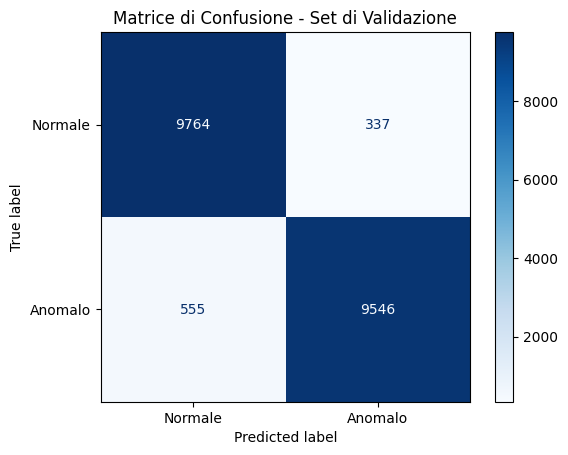

In [ ]:
# Calcolo dell'errore di ricostruzione sul set di validazione
reconstruction_error = np.mean(np.square(X_val - X_val_pred), axis=1)

# Determina una soglia ottimale basata sulla curva ROC
fpr, tpr, thresholds = roc_curve(y_val, reconstruction_error)
optimal_idx = np.argmax(tpr - fpr)
threshold = thresholds[optimal_idx]

# Calcolo della curva ROC
roc_auc = auc(fpr, tpr)

# Grafico della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color='blue')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f"Optimal Point (Threshold = {threshold:.2e})")

# Etichette e legenda
plt.title("ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

precision_roc, recall_roc, f1_roc = evaluate_threshold(threshold, "ROC", X_val_pred)

# Calcolo del vettore di errore di ricostruzione

Dal paper: *Torabi, Hasan, Seyedeh Leili Mirtaheri, and Sergio Greco. "Practical autoencoder based anomaly detection by using vector reconstruction error." Cybersecurity 6.1 (2023): 1*

Dopo la fase di addestramento, viene calcolata una threshold rappresentata da un **vettore di errore di ricostruzione**, che consente di definire una soglia specifica per ciascuna feature.
Per classificare una nuova istanza, si calcola il vettore dell'errore di ricostruzione associato all'istanza stessa e lo si confronta con il vettore di threshold. L'istanza viene classificata come anomala nel momento in cui almeno una delle feature presenta un valore di errore superiore alla soglia corrispondente. Questo metodo garantisce una valutazione dettagliata e personalizzata delle features.

Il calcolo del vettore di errore di ricostruzione avviene seguendo un processo iterativo. Si parte inizializzando un vettore nullo, che fungerà da riferimento durante tutta l'elaborazione. Successivamente, si utilizza l'autoencoder addestrato, applicandolo a ciascuna istanza del dataset di training. Per ogni istanza, si calcola il vettore dell'errore di ricostruzione.
A ogni iterazione, il vettore dell'errore di ricostruzione calcolato per l'istanza corrente viene confrontato con il vettore di errore accumulato fino a quel momento. Per ciascuna feature, viene selezionato il valore massimo tra il vettore corrente e quello accumulato. Questo aggiornamento permette di ottenere un vettore finale che rappresenta il massimo errore di ricostruzione osservato per ciascuna feature nel dataset di training.
Secondo quanto indicato dal paper originale, l'errore di ricostruzione deve essere calcolato come il valore assoluto della differenza tra i valori dell'istanza ricostruita e quelli dell'istanza originale.

L'immagine presenta lo pseudocodice del calcolo della threshold:
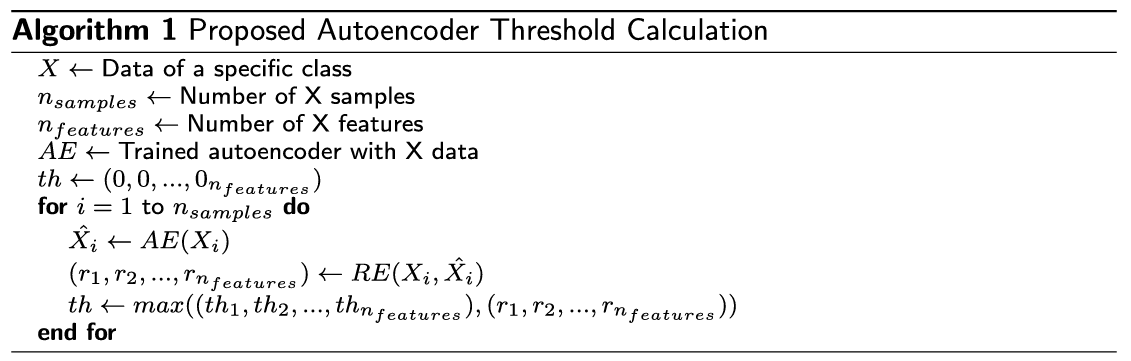

In [ ]:
def calculate_threshold_per_feature(X, autoencoder):
    """
    Calcola la soglia (threshold) per ogni feature.

    Args:
        X (numpy array): Dati di input della classe specifica, shape (n_samples, n_features).
        autoencoder (tf.keras.Model): Modello autoencoder addestrato.

    Returns:
        numpy array: Soglie per ogni feature, shape (n_features,).
    """
    # Converte il DataFrame in un array NumPy se necessario
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    # Ricostruzione di tutti i campioni in un unico batch
    X_reconstructed = autoencoder.predict(X)

    # Calcolo degli errori di ricostruzione per ogni feature e campione
    reconstruction_errors = np.abs(X - X_reconstructed)

    # Calcolo delle soglie per ogni feature come massimo degli errori
    thresholds = np.max(reconstruction_errors, axis=0)

    return thresholds

thresholds=calculate_threshold_per_feature(X_train, model)

1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Report di classificazione sul set di validazione con threshold vettoriale:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     10101
           1       0.99      0.94      0.96     10101

    accuracy                           0.97     20202
   macro avg       0.97      0.97      0.97     20202
weighted avg       0.97      0.97      0.97     20202



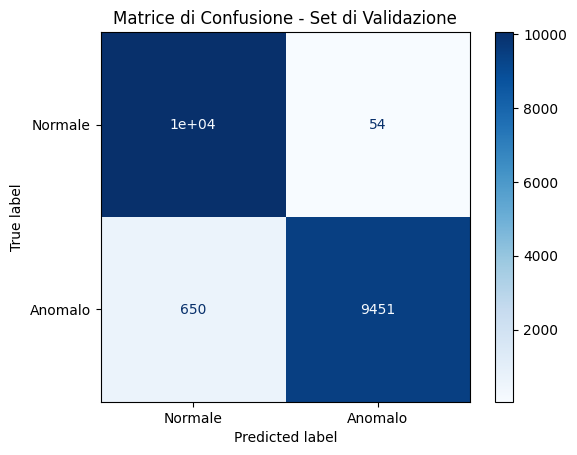

In [ ]:
# Differenza assoluta tra input originale e ricostruito
val_loss = tf.abs(X_val_pred - X_val)

# Confronta ogni errore con la soglia corrispondente
is_anomalous = np.any(val_loss > thresholds, axis=1)  # Shape: (n_samples,)

# Classifica i campioni (1 = anomalo, 0 = normale)
labels = is_anomalous.astype(int)

print("Report di classificazione sul set di validazione con threshold vettoriale:")
report = classification_report(y_val, labels)
print(report)
precision_vector=precision_score(y_val, labels)
recall_vector=recall_score(y_val, labels)
f1_vector = f1_score(y_val, labels, average='weighted')

# Matrice di confusione per il set di validazione
cm_val = confusion_matrix(y_val, labels)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=["Normale", "Anomalo"])
disp_val.plot(cmap="Blues")
plt.title("Matrice di Confusione - Set di Validazione")
plt.show()

# Confronto dei risultati ottenuti
Confrontiamo i risultati ottenuti sul validation set. Come metriche di riferimento consideriamo la *weighted average F1-score*, la *precision* e la *recall*. Abbiamo scelto queste metriche in quanto la wighted avg F1-score bilancia precision e recall, fornendo una misura che tiene conto delle due fonti principali di errore (falsi positivi e falsi negativi). Oltre alla media armonica delle due poi ci interessa valutare precision e recall singolarmente in modo da poter scegliere se considerare il modello che ne massimizza una o l'altra.

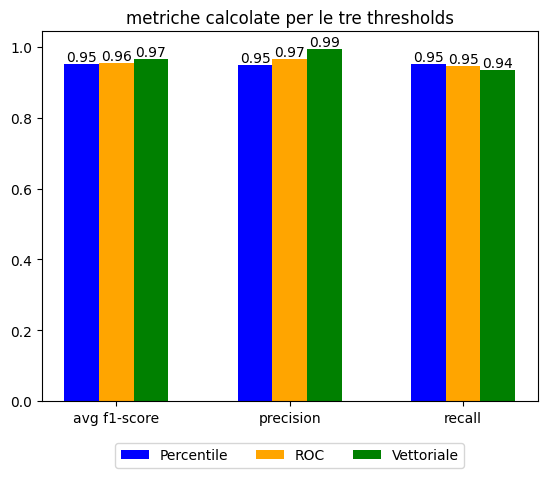

In [ ]:
# Dati
categories = ['avg f1-score', 'precision', 'recall']
percentile=[f1_percentile, precision_percentile, recall_percentile]
roc=[f1_roc, precision_roc, recall_roc]
vector=[f1_vector, precision_vector, recall_vector]

# Creare un array di posizioni per le barre
x = np.arange(len(categories))

# Definire larghezza delle barre
width = 0.2

# Creare subplots per più istogrammi
fig, ax = plt.subplots()

# Aggiungere più istogrammi, con uno spostamento orizzontale
bars_percentile = ax.bar(x - width, percentile, width, label='Percentile', color='blue')
bars_roc = ax.bar(x, roc, width, label='ROC', color='orange')
bars_vector = ax.bar(x + width, vector, width, label='Vettoriale', color='green')

# Aggiungere valore sopra ogni barra
for bar in bars_percentile:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(round(height, 2)), ha='center', va='bottom')

for bar in bars_roc:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(round(height, 2)), ha='center', va='bottom')

for bar in bars_vector:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(round(height, 2)), ha='center', va='bottom')

# Aggiungere titolo
ax.set_title('metriche calcolate per le tre thresholds')

# Posizionare le etichette centrali sull'asse X
ax.set_xticks(x)  # Posizioniamo i tick sull'asse X
ax.set_xticklabels(categories)  # Le etichette sono le categorie (le metriche)

# Aggiungere una legenda
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)


# Mostrare il grafico
plt.show()

Dai risultati ottenuti sul set di validazione, il modello che riporta le prestazioni migliori è quello che utilizza la soglia calcolata tramite ROC. Questa scelta è motivata dal fatto che il nostro obiettivo prioritario è ottenere una **recall** più **elevata**.
Nel contesto dell'intrusion detection, è infatti fondamentale identificare il maggior numero possibile di attacchi, anche a costo di etichettare come attacchi alcuni esempi di traffico normale. Questo approccio minimizza il rischio di perdere attacchi reali, un aspetto critico per il nostro scenario d'applicazione. Inoltre, la threshold ROC presenta buoni risultati anche sulle altre metriche.

# Valutazione su test set

Nonostante il modello finale scelto è quello basato su threshold ROC, nella trattazione che segue andremo comunque a valutare le performance delle varie thresholds sul test set per motivi di completezza.

In [ ]:
def evaluate_threshold_test_set(threshold, threshold_type, X_test_pred):

  test_reconstruction_error = np.mean(np.square(X_test - X_test_pred), axis=1)
  test_y_pred = (test_reconstruction_error > threshold).astype(int)

  print("Report di classificazione sul set di test con threshold " + threshold_type + " :")
  print(classification_report(y_test, test_y_pred, zero_division=0))

  # Matrice di confusione per il set di test
  cm_test = confusion_matrix(y_test, test_y_pred)
  disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Normale", "Anomalo"])
  disp_test.plot(cmap="Blues")
  plt.title("Matrice di Confusione - Set di Test")
  plt.show()

## $95^°$ Percentile

632/632 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Report di classificazione sul set di test con threshold percentile :
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10102
           1       0.95      0.95      0.95     10102

    accuracy                           0.95     20204
   macro avg       0.95      0.95      0.95     20204
weighted avg       0.95      0.95      0.95     20204



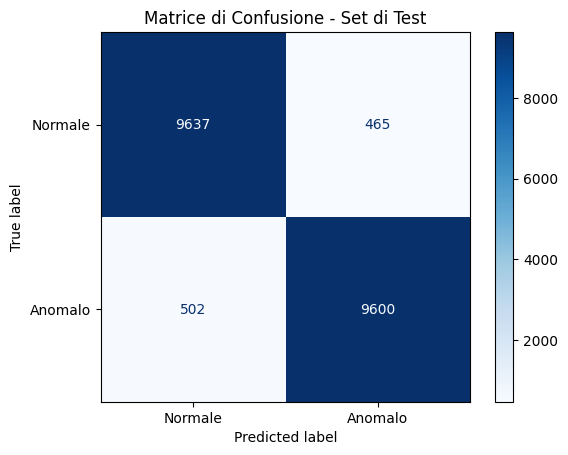

In [ ]:
# Valutazione sul set di test
X_test_pred = model.predict(X_test)
evaluate_threshold_test_set(threshold_percentile, "percentile", X_test_pred)

## Youden's Index

Report di classificazione sul set di test con threshold ROC :
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     10102
           1       0.97      0.95      0.96     10102

    accuracy                           0.96     20204
   macro avg       0.96      0.96      0.96     20204
weighted avg       0.96      0.96      0.96     20204



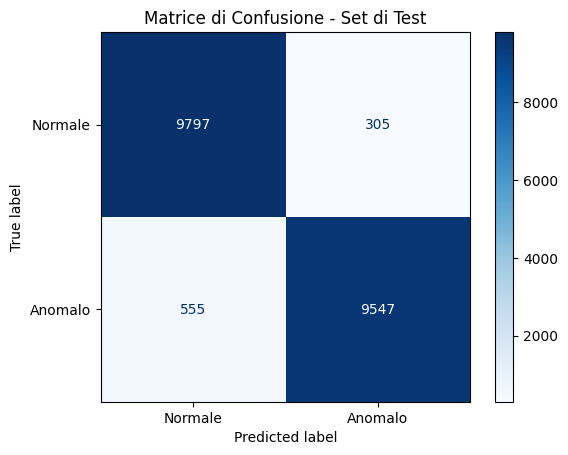

In [ ]:
evaluate_threshold_test_set(threshold, "ROC", X_test_pred)

## Threshold vettoriale

Report di classificazione sul set di test con threshold vettoriale:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10102
           1       1.00      0.93      0.96     10102

    accuracy                           0.96     20204
   macro avg       0.97      0.96      0.96     20204
weighted avg       0.97      0.96      0.96     20204



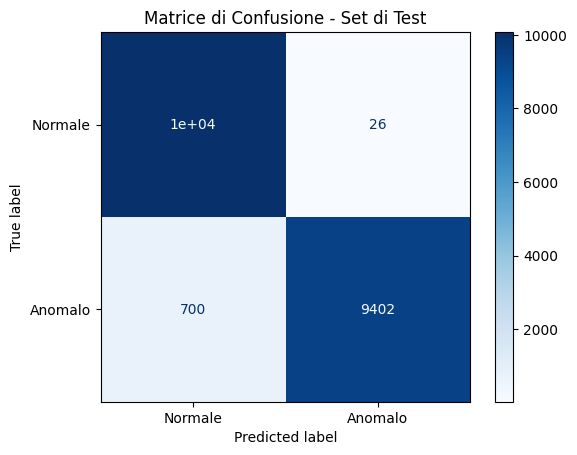

In [ ]:
# Differenza assoluta tra input originale e ricostruito
test_loss = tf.abs(X_test_pred - X_test)

# Confronta ogni errore con la soglia corrispondente
is_anomalous = np.any(test_loss > thresholds, axis=1)  # Shape: (n_samples,)

# Classifica i campioni (1 = anomalo, 0 = normale)
labels = is_anomalous.astype(int)

print("Report di classificazione sul set di test con threshold vettoriale:")
print(classification_report(y_test, labels))

# Matrice di confusione per il set di test
cm_test = confusion_matrix(y_test, labels)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Normale", "Anomalo"])
disp_val.plot(cmap="Blues")
plt.title("Matrice di Confusione - Set di Test")
plt.show()